# Lab 4: Building a Spotify Song Classifier with KNNs and Decision Trees
**Classify by genres**. In this lab, you will build machine learning genre classifiers using a dataset of Spotify tracks. Your goal is to train a model that can distinguish between two selected genres based on various audio features such as danceability, energy, valence, tempo, and more.

We'll follow the familiar workflow of data exploration -> preprocessing -> model training -> evaluation

In [1]:
import pandas as pd
from sklearn.preprocessing import LabelEncoder
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.neighbors import KNeighborsClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.metrics import accuracy_score
import numpy as np
import matplotlib.pyplot as plt

### Step 1: The data
We'll focus on two genres: Blues and Jazz (what’s the difference, anyway??).

Both genres have rich musical histories, but they differ in structure:

- Blues tends to have simpler chord progressions and a strong emotional expression.
- Jazz often involves complex improvisation and more varied rhythms.

But can a machine really tell them apart just by looking at numerical audio features? That’s what we’ll find out!

In this step, you will:
- Load the dataset
- Extract only blues and jazz for classification

In [2]:
spotify_data = pd.read_csv('/courses/EDS232/Data/spotify_dat.csv')

# Print the data types in spotify_data
print(f'Spotify DF Data Types:\n{spotify_data.dtypes}')

# Filter down to two genres
blues_data = spotify_data[spotify_data['genres'] == 'blues']
jazz_data = spotify_data[spotify_data['genres'] == 'jazz']

# Combine both genres into one dataset
combined_data = blues_data.append(jazz_data, ignore_index = True)

# Rename 'genres' column to 'genre' for clarity
combined_data = combined_data.rename(columns = {'genres' : 'genre'})


Spotify DF Data Types:
id                   object
name                 object
album                object
album_id             object
artists              object
artist_ids           object
track_number          int64
disc_number           int64
explicit               bool
danceability        float64
energy              float64
key                   int64
loudness            float64
mode                  int64
speechiness         float64
acousticness        float64
instrumentalness    float64
liveness            float64
valence             float64
tempo               float64
duration_ms           int64
time_signature      float64
year                  int64
release_date         object
genres               object
dtype: object


## Step 2: Data Exploration
Now that we have Blues and Jazz as our two genres, it's time to explore the data and look for patterns in the audio features.

Let's investigate:
- Which features are available?
    - The available features are track number, disc_number, danceability, energy, key, loudness, mode, speechiness, acousticness, instrumentalness, liveness, valence, tempo, duration_ms, time_signature, and year.
- How strongly these features correlate with each other.
    - The most notable correlations are...
        - loudness and energy at about 0.8
        - valence and danceability, energy, and loudness at about 0.5, 0.62, and 0.5 respectively
        - energy and acousticness, instrumentalness are negatively correlated at -0.71 and -0.37 respectively
        - acousticness is also negatively correlated with loudness and valence at about -0.55 and -0.44 respectively
        - instrumentalness is also negatively correlated with loudness and valence at about -0.49 and -0.4.
- How different genres distribute across  sample features: danceability 
    - valence and loudness are somewhat correlated at about 0.5 and 0.25 respectively
    - instrumentalness and duration are somewhat negatively correlated at about -0.3 and -0.21 respectively

In this step, we will:
- Filter out non-numeric columns before the plotting
- Visualize feature correlations using a heatmap.
- Examine key feature distributions with histograms to see if genres behave differently.


In [3]:
# Exclude non-numeric columns but keep 'genre' for grouping

# returns only numeric features
def get_numeric_features(df):
    numeric_cols = []
    for dtype, column in zip(df.dtypes, df.columns):
        if dtype in ['int64', 'float64']:
            numeric_cols.append(column)
    return numeric_cols

numeric_features = (combined_data[get_numeric_features(combined_data)]
                    .drop(['track_number', 'disc_number'], axis = 1)
                    .assign(genre = combined_data['genre'])) # include genre


<AxesSubplot:>

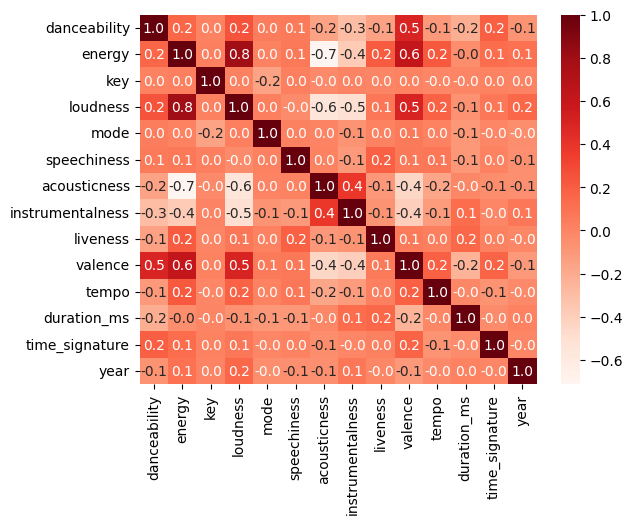

In [4]:
plt.figure()

sns.heatmap(
            numeric_features.corr(), # recreates dataframe to get correlations between variables
            cmap = 'Reds', 
            annot = True, 
            fmt = '.1f'
)

/opt/python/3.7.13/lib/python3.7/site-packages/pandas/plotting/_matplotlib/tools.py:225: UserWarning: When passing multiple axes, layout keyword is ignored
  "When passing multiple axes, layout keyword is ignored", UserWarning


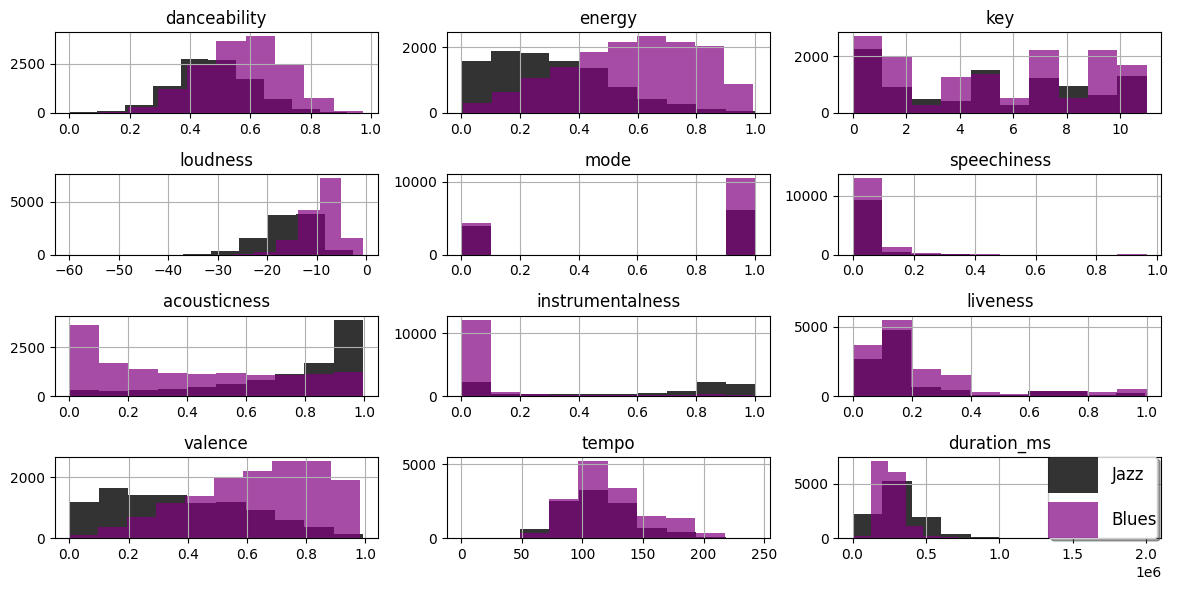

In [5]:
# get relevant features and split
major_features = numeric_features.drop(['year', 'time_signature'], axis = 1)
blues = major_features[major_features['genre'] == 'blues']
jazz = major_features[major_features['genre'] == 'jazz']

# init jazz hists
ax = jazz.hist(layout = (4,3), alpha=0.8, color = 'black', figsize = (12,6), label = 'Jazz')

# init blues hists
blues.hist(ax=ax, layout=(4,3), alpha=0.7, color='purple', label = 'Blues')

plt.legend(borderpad = 0, handlelength = 3, handleheight = 3, fontsize = 'large', loc = (0.65,0), frameon = True, shadow = True)

# fix constraint issues
plt.tight_layout()

plt.show()

### Step 3: Check for class imbalance
An unequal distribution between the target classes can cause issues for our classifiers, so we'll need to check for that. A commonly used guideline for class imbalance is:

- Slight Imbalance (Less than 1.5:1) → Generally okay; no need for balancing.
- Moderate Imbalance (Between 1.5:1 and 3:1) → Might cause some bias; balancing can help.
- Severe Imbalance (More than 3:1) → Strongly affects model performance; balancing is usually necessary.

In [6]:
# Print counts of each genre
class_counts = numeric_features['genre'].value_counts().sort_values()

# Calculate ratio of majority to minority class
class_ratio = f'{(class_counts[1] / class_counts[0]).round(3)} : 1'

# Print class distribution and ratio
print(f'Class distribution ratio for blues/jazz: {class_ratio}')

Class distribution ratio for blues/jazz: 1.478 : 1


Given this result, should we be worried about the imbalance?

Maybe but probably not. It is right at the cusp between slight and moderate imbalance, so it may cause enough bias to raise an eyebrow, but maybe not enoough to need balancing.

### Step 4: Preprocessing
We need to ensure all the variables we use are numerical so the models can process them. First we'll drop all the variables that are not numeric or the target. Then we'll use a sklearn utility, `LabelEncoder()` to encode our categorical target variable into numerical values. Print the first five values of your encoded labels.

In [7]:
# Define the features (drop columns that are not numeric or target)
X = combined_data[get_numeric_features(numeric_features)]

# Set the target variable as 'genre'
y = combined_data.genre

# Encode the target variable ('label') using label encoding
label_encoder = LabelEncoder()
y_encoded = label_encoder.fit_transform(y)

# Print first five values of encoded labels
print(f'First five values of the encoded genre labels: {y_encoded[:5]}')

First five values of the encoded genre labels: [0 0 0 0 0]


Good, now we'll do our data splitting and scaling.  Let's go with an 80/20 split this time.

In [8]:
# Split data into 80% train and 20% test
X_train, X_test, y_train, y_test = train_test_split(X, y_encoded, test_size = 0.20, random_state = 42)

# Initialize the scaler
scaler = StandardScaler()

# Fit and transform only the training set
X_train_scaled = scaler.fit_transform(X_train)

# Use the same scaler to transform the test set
X_test_scaled = scaler.transform(X_test)

### Step 5: Train the models
OK, now it's time to build our models and assess the training accuracy. We'll use the default of k = 5 for the KNN model.

In [9]:
# Initialize models
knn = KNeighborsClassifier(5)
dt = DecisionTreeClassifier()

# Train (fit) both models
knn_fit = knn.fit(X_train_scaled, y_train)
dt_fit = dt.fit(X_train_scaled, y_train)

# Predictions on training data
knn_y_train_pred = knn_fit.predict(X_train_scaled)
dt_y_train_pred = dt_fit.predict(X_train_scaled)

# Compute training accuracy
knn_train_accuracy = accuracy_score(y_train, knn_y_train_pred)
dt_train_accuracy = accuracy_score(y_train, dt_y_train_pred)

# Print training accuracy for both models
print(f'K nearest neighbor model accuracy (with training data): {knn_train_accuracy:.3f}')
print(f'Decision tree model accuracy (with training data): {dt_train_accuracy}')

K nearest neighbor model accuracy (with training data): 0.922
Decision tree model accuracy (with training data): 1.0


### Step 6: Evaluate models
OK, now let's go ahead and predict on the test data to see how well our models do at predicting the genre of unseen tracks.

In [10]:
# Make predictions
knn_pred = knn_fit.predict(X_test_scaled)
dt_pred = dt_fit.predict(X_test_scaled)

# Evaluate prediction accuracy
knn_accuracy = accuracy_score(y_test, knn_pred)
dt_accuracy =  accuracy_score(y_test, dt_pred)

#Print prediction accuracy for both models
print(f'K nearest neighbor model accuracy: {knn_accuracy:.3f}')
print(f'Decision tree model accuracy: {dt_accuracy:.3f}')

K nearest neighbor model accuracy: 0.887
Decision tree model accuracy: 0.852


### Step 7: Visualizing Model Performance
Now that we have evaluated our models on unseen data, let’s compare their performance by visualizing the training vs. test accuracy.  We'll look for signs of overfitting by plotting the training accuracy and test accuracy for both k-NN and Decision Trees.

Create a bar chart that compares the training accuracy and test accuracy for k-NN and Decision Trees. Your plot should clearly display:

- The training and test accuracy for both models.
- Properly labeled axes and a title.
- A legend to differentiate training and test accuracy.
- Accuracy values displayed on top of each bar.

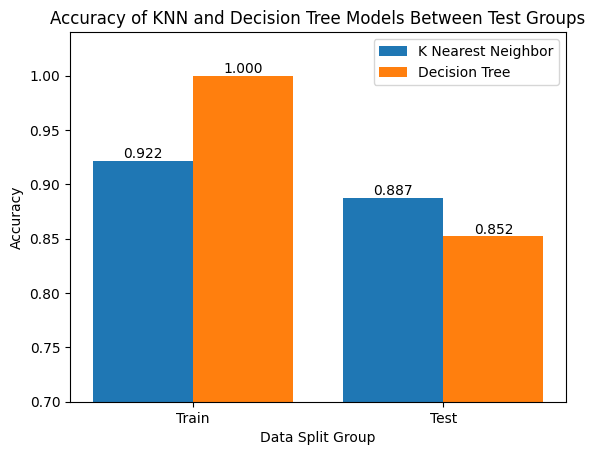

In [11]:
x = ['Train', 'Test'] # init x labels
knn_vals = [knn_train_accuracy, knn_accuracy]
dt_vals = [dt_train_accuracy, dt_accuracy]

# array of two values, 0 and 1
x_axis = np.arange(len(x)) 

# plot KNN and DT accuracies side by side for taining and test
knn_bar = plt.bar(x_axis - 0.2, knn_vals, 0.4, label = 'K Nearest Neighbor')
dt_bar = plt.bar(x_axis + 0.2, dt_vals, 0.4, label = 'Decision Tree')

plt.xticks(x_axis, x) # set x labels
plt.xlabel('Data Split Group')
plt.ylabel('Accuracy')
plt.title('Accuracy of KNN and Decision Tree Models Between Test Groups')
plt.ylim([0.7, 1.04])
plt.legend()

# set accuracy values over bars
plt.bar_label(knn_bar, fmt = '%.3f')
plt.bar_label(dt_bar, fmt = '%.3f')

plt.show()

Which model does a better job of generalizing to unseen data? How do you know?
Does it appear that either of the models are overfitting? Why?

The KNN model is more generalized. The accuracies of the decision tree suggest that it is overfitting. This is because its accuracy with the training data is perfect, but it's accuracy with the test data is less than that of the KNN. The KNN in comparison may not have a perfect accuracy with the training data but some error there is actually a good thing. Furthermore it's accuracy when run on the test data is similarly good.

### Bonus question
In the workflow above, we used the default parameter values of k = 5 for the KNN model, and maxdepth = None for the Decision Tree. Choose one of the models and see if you can improve test performance by optmizing its corresponding parameter value.

In [12]:
# init empty list for k values
k_list = []

# test k values from 1 to 50
for k in list(range(1,51)):
    if k == 1:
        print('Beginning Testing of k values...')
    if k % 5 == 0: 
        print(f'Processing k = {k}...')
    
    # train KNN based on given k value
    knn_test = KNeighborsClassifier(k).fit(X_train_scaled, y_train)
    
    # append output to list
    k_list.append(knn_test.predict(X_test_scaled))
    
    if k == 50: 
        print('Testing finished.')

Beginning Testing of k values...
Processing k = 5...
Processing k = 10...
Processing k = 15...
Processing k = 20...
Processing k = 25...
Processing k = 30...
Processing k = 35...
Processing k = 40...
Processing k = 45...
Processing k = 50...
Testing finished.


In [13]:
# init list for accuracies
k_accuracies = []

# get accuracies for KNN with k values from 1 to 50
for k in list(range(0,50)):
    
    # get accuracy for given k
    curr_accuracy = accuracy_score(y_test, k_list[k])
    
    # append to list
    k_accuracies.append(curr_accuracy)

# get k value with largest accuracy
for k in k_accuracies:
    if k == max(k_accuracies):
        print(f'Optimal k value: {k_accuracies.index(k) + 1}')
        print(f'Associated accuracy: {k_accuracies[k_accuracies.index(k)]}')

Optimal k value: 11
Associated accuracy: 0.8922891081135494


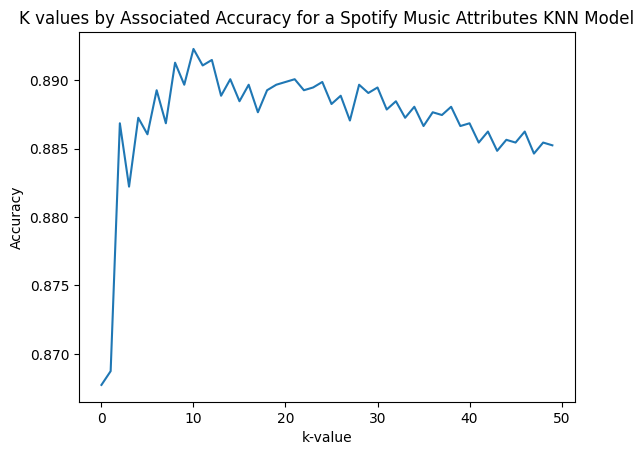

In [14]:
# create k-value figure
plt.figure()

plt.plot(k_accuracies)

plt.ylabel('Accuracy')
plt.xlabel('k-value')
plt.title('K values by Associated Accuracy for a Spotify Music Attributes KNN Model')

plt.show()